# Установка пакетов

In [1]:
!python3 -m pip install diffusers==0.21.*

Python 


# Импорт библиотек

In [3]:
import os
import math

from pathlib import Path
from dataclasses import dataclass

import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
from datasets import load_dataset
from diffusers import UNet2DModel, DDPMScheduler, DDPMPipeline
from diffusers.optimization import get_cosine_schedule_with_warmup
from accelerate import notebook_launcher, Accelerator
from huggingface_hub import HfFolder, Repository, whoami
from tqdm.autonotebook import tqdm

#### MODEL_OUTPUT_DIR = Path("C:/Users/ekart/Alex_icon_gennerator/ddpm-fake-icons")

* Создаёт объект Path для директории, в которой будут сохраняться результаты работы модели (например, сгенерированные изображения, веса модели). Это делает работу с файловыми путями более удобной, поскольку Path предоставляет множество методов для манипулирования путями.

#### LOG_DIR = Path(MODEL_OUTPUT_DIR).joinpath("logs")

* Создаёт объект Path для директории логов, где могут сохраняться логи процесса обучения. Это делается путём добавления поддиректории logs к пути MODEL_OUTPUT_DIR.

#### INPUT_IMG_PATH = Path("C:/Users/ekart/Alex_icon_gennerator/archive (13)/Icons-50/Icons-50")

* Создаёт объект Path для директории, где находятся исходные изображения иконок, которые будут использоваться для обучения модели.

#### OUTPUT_IMG_PATH = Path("C:/Users/ekart/Alex_icon_gennerator/sq_images")

* Создаёт объект Path для директории, в которую будут сохраняться предобработанные изображения (например, изображения могут быть изменены до определённого размера перед обучением модели).

#### OUTPUT_IMG_PATH.mkdir(parents=True, exist_ok=True)

* Используя метод mkdir объекта Path, создаёт директорию, указанную в OUTPUT_IMG_PATH, если она ещё не существует. Параметр parents=True указывает на необходимость создать все родительские директории, если они отсутствуют. exist_ok=True говорит, что ошибки, связанные с существованием директории, игнорируются.

#### INPUT_IMG_PATH.exists() & OUTPUT_IMG_PATH.exists()

* Проверяет, существуют ли указанные директории для исходных и предобработанных изображений. Оператор & используется для логического "И", чтобы убедиться, что обе директории существуют. Возвращает True, если обе директории существуют, и False в противном случае.

In [4]:
MODEL_OUTPUT_DIR = Path("C:/Users/ekart/Alex_icon_gennerator/ddpm-fake-icons")
LOG_DIR = Path(MODEL_OUTPUT_DIR).joinpath("logs")
INPUT_IMG_PATH = Path("C:/Users/ekart/Alex_icon_gennerator/archive (13)/Icons-50/Icons-50")
OUTPUT_IMG_PATH = Path("C:/Users/ekart/Alex_icon_gennerator/sq_images")
OUTPUT_IMG_PATH.mkdir(parents = True, exist_ok = True)
INPUT_IMG_PATH.exists() & OUTPUT_IMG_PATH.exists()

True

# Подготовка данных

* Сведение изображений к квадрату
* Увеличение изображений до квадрата без искажения соотношения сторон

In [16]:
# Функция для преобразования изображений в квадратный формат, заполняя фоновым цветом
def expand2square(pil_img, background_color):
    width, height = pil_img.size  # Получение размеров изображения
    # Если изображение уже квадратное, возвращаем его без изменений
    if width == height:
        return pil_img
    elif width > height:
        # Создаём новое изображение с необходимыми размерами и фоном, если ширина больше высоты
        result = Image.new(pil_img.mode, (width, width), background_color)
        # Вставляем исходное изображение в центр нового, чтобы оно стало квадратным
        result.paste(pil_img, (0, (width - height) // 2))
        return result
    else:
        # Создаём новое изображение с необходимыми размерами и фоном, если высота больше ширины
        result = Image.new(pil_img.mode, (height, height), background_color)
        # Вставляем исходное изображение в центр нового, чтобы оно стало квадратным
        result.paste(pil_img, ((height - width) // 2, 0))
        return result

# Перебираем все PNG-изображения в указанной директории и её поддиректориях
for i, img_path in enumerate(tqdm(INPUT_IMG_PATH.glob("**/*.png"))):
    # Применяем функцию преобразования к каждому изображению, делая его квадратным и меняя формат на RGB
    im_square = expand2square(Image.open(img_path).convert('RGB'), (0, 0, 0))
    # Сохраняем преобразованное изображение в новой директории, назначая имя файла с ведущими нулями
    im_square.save(OUTPUT_IMG_PATH.joinpath(f"{i + 1:0>5}.jpeg"), quality = 100)

# Выводим количество файлов в целевой директории, чтобы проверить, все ли изображения были обработаны
print(len(list(OUTPUT_IMG_PATH.iterdir())))


0it [00:00, ?it/s]

10000


## Загрузка данных на основе конфигурации обучения
### Параметры конфигурации обучения:

#### Image size
* Разрешение изображения для обучения и генерации.
#### Num Inference Steps
* Количество шагов обесцвечивания для генерации изображения.
#### Train Batch Size
* Размер партии при обучении. Влияет на пиковое использование памяти GPU и время обучения.
#### Evaluation Batch Size
* Размер партии во время оценки. Влияет на пиковое использование памяти GPU во время оценки.
#### Num Epochs
* Количество эпох обучения.
#### Gradient Accumulation Steps
* Количество шагов перед каждым проходом назад. Эффективный размер партии, т. е. размер шага, равен train_batch_size * gradient_accumulation_steps.
#### Learning Rate
* Скорость обучения во время тренировки.
#### LR Warmup Steps
* Количество шагов перед затуханием LR с использованием выбранного планировщика (здесь - косинус).
#### Save Image Epochs
* Количество эпох, после каждой из которых сгенерированные образцы изображений сохраняются на диск.
#### Save Model Epochs
* Количество эпох, после которых контрольные точки модели сохраняются на диск.
#### Mixed Precision
* Установите значение no для float32 и fp16 для автоматической смешанной точности.
#### Output Dir
* Каталог, в который следует сохранить модель.
#### Push To Hub
* Передавать ли модель в концентратор HuggingFace после обучения.
#### Seed
* Случайное зерно для ГПСЧ для генерации обучающих образцов.
#### Dataset Name
* Имя конфигурации, указывающее, откуда загружать данные. Установите значение imagefolder для загрузки изображений с диска.

In [6]:
# Использование dataclass для упрощения определения класса конфигурации
@dataclass
class TrainingConfig:
    # Размер стороны квадратного изображения для обучения и инференции
    image_size = 128
    # Количество шагов инференции, используемых при генерации изображений
    num_inference_steps = 1000
    # Размер батча для обучения
    train_batch_size = 16
    # Размер батча для оценки
    eval_batch_size = 16
    # Количество эпох обучения
    num_epochs = 32
    # Шаги накопления градиента для реализации больших батчей на ограниченной памяти GPU
    gradient_accumulation_steps = 2
    # Скорость обучения
    learning_rate = 1e-4
    # Количество шагов разогрева для планировщика скорости обучения
    lr_warmup_steps = 2000
    # Частота сохранения сгенерированных изображений во время обучения (каждые 10 эпох)
    save_image_epochs = 10
    # Частота сохранения модели во время обучения (каждые 10 эпох)
    save_model_epochs = 10
    # Использование смешанной точности для ускорения обучения и снижения потребления памяти
    mixed_precision = 'fp16'
    # Директория для сохранения результатов обучения и сгенерированных изображений
    output_dir = MODEL_OUTPUT_DIR
    # Флаг для возможности публикации модели на Hugging Face Hub (не используется в данном примере)
    push_to_hub = False
    # Сид для инициализации генератора случайных чисел, обеспечивает воспроизводимость результатов
    seed = 7

# Создание экземпляра конфигурации
config = TrainingConfig()
# Установка имени датасета для загрузки, здесь предполагается, что датасет организован как папки с изображениями
config.dataset_name = "imagefolder"
# Загрузка датасета из указанной директории, предполагается использование библиотеки, поддерживающей такой формат загрузки
dataset = load_dataset(config.dataset_name, data_dir = OUTPUT_IMG_PATH, split = "train")
# Вывод информации о загруженном датасете для проверки
dataset


Resolving data files:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['image'],
    num_rows: 10000
})

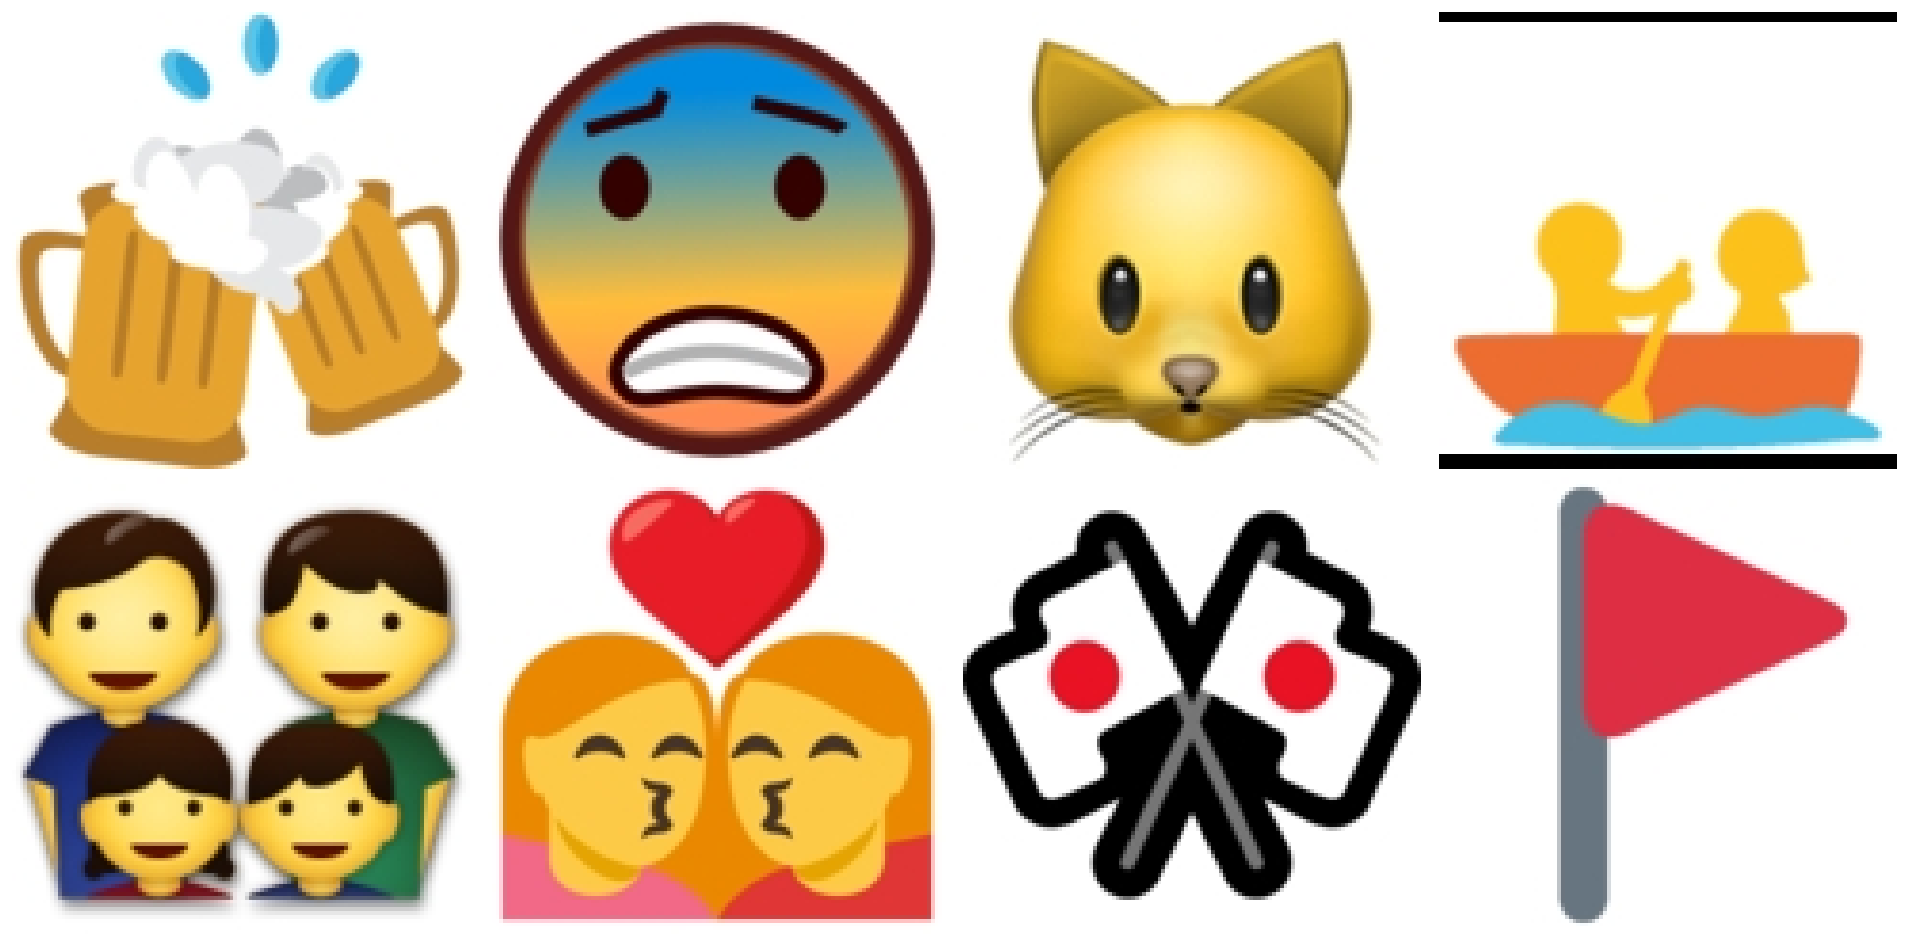

In [7]:
# Выбираем случайные индексы из датасета, чтобы показать восемь случайных изображений
sample_ids = np.random.randint(len(dataset), size=8)

# Настраиваем размер и разрешение фигуры для отображения изображений
plt.figure(figsize=(16, 8), dpi=120)
# Перебираем выбранные изображения для отображения
for i, image in enumerate(dataset[sample_ids]["image"]):
    # Для каждого изображения создаём подграфик в решётке 2x4
    plt.subplot(2, 4, i + 1)
    # Отображаем изображение
    plt.imshow(image)
    # Убираем оси для более чистого визуального представления
    plt.axis(False)
# Автоматически настраиваем подграфики, чтобы они не перекрывали друг друга
plt.tight_layout()
# Отображаем все подграфики
plt.show()


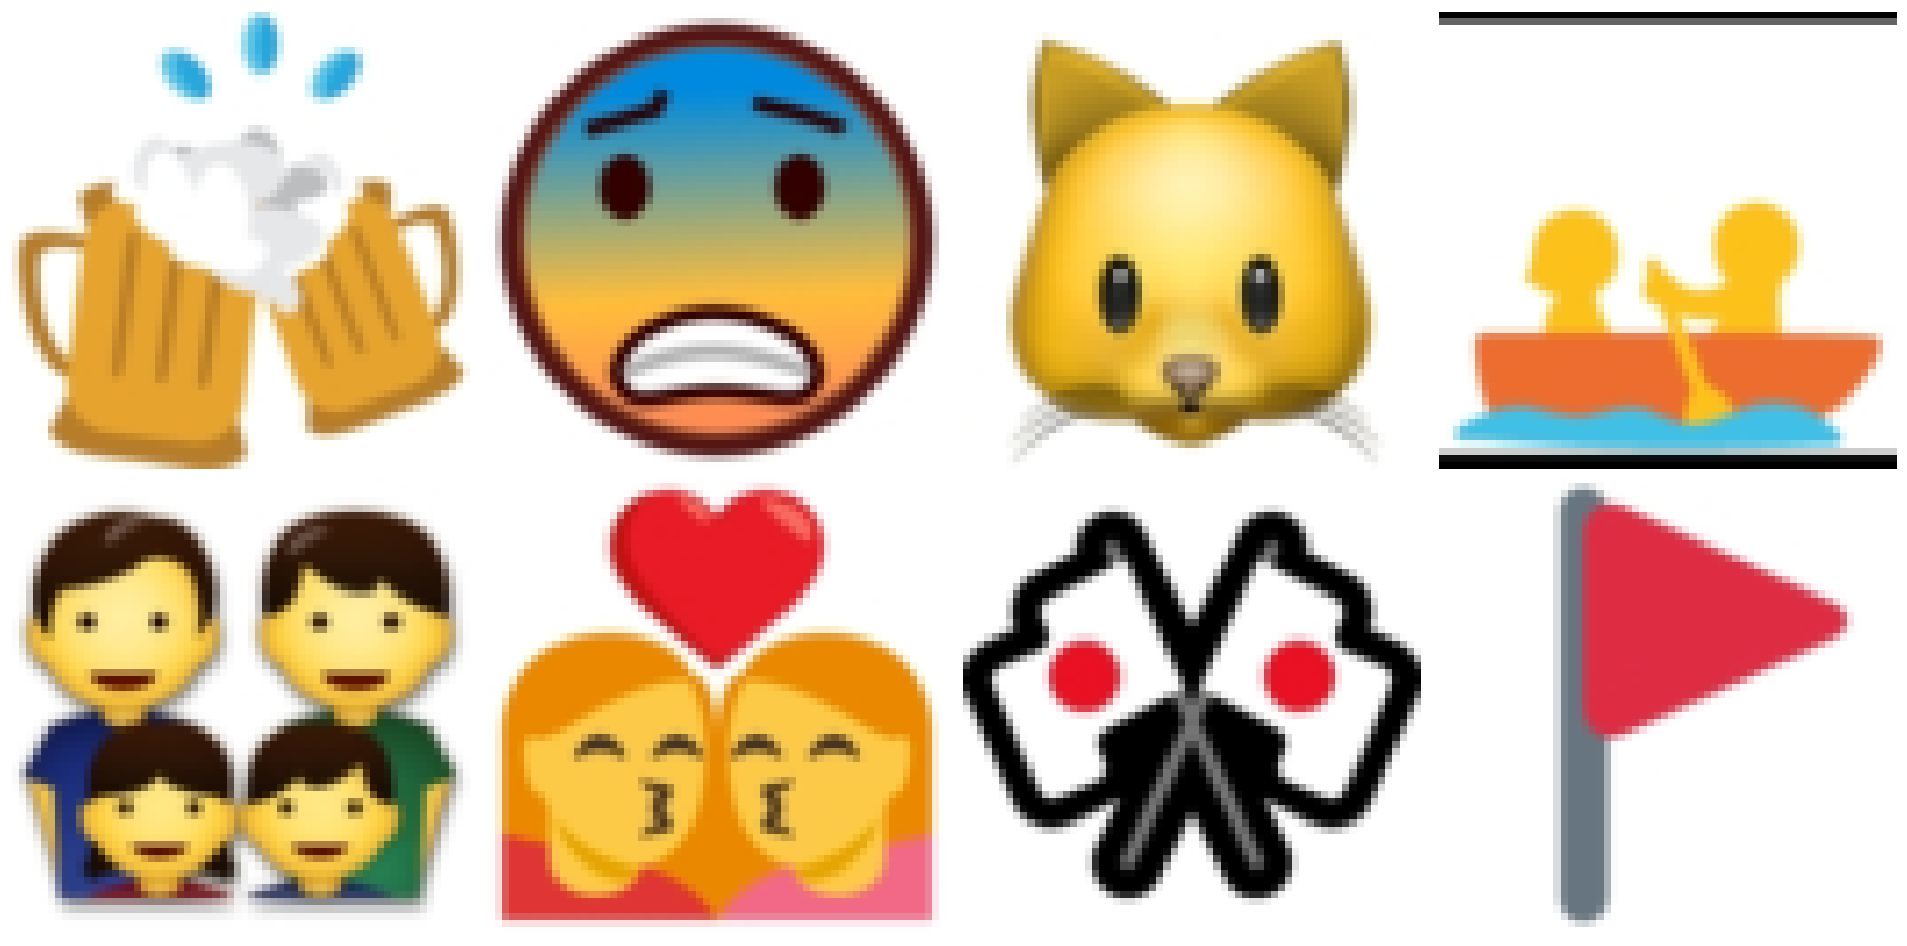

In [8]:
# Обновление размера изображения для преобразований
config.image_size = 64  # Установите новый размер изображения здесь

# Определение цепочки преобразований для изображений
preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),  # Изменение размера изображений до заданного
        transforms.RandomHorizontalFlip(),  # Случайное отражение изображения по горизонтали для аугментации
        transforms.ToTensor(),  # Преобразование изображений в тензоры PyTorch
        transforms.Normalize([0.5], [0.5]),  # Нормализация изображений
    ]
)

# Функция для применения определённых преобразований к изображениям в датасете
def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

# Применение преобразований к датасету
dataset.set_transform(transform)

# Визуализация преобразованных изображений
plt.figure(figsize = (16, 8), dpi = 120)
for i, image in enumerate(dataset[sample_ids]["images"]):
    # Размещение каждого изображения в отдельном подграфике в решётке 2x4
    plt.subplot(2, 4, i + 1)
    # Перестановка осей изображения для отображения и корректировка нормализации для визуализации
    plt.imshow(image.permute(1, 2, 0).numpy() / 2 + 0.5)
    plt.axis(False)  # Скрытие осей
plt.tight_layout()  # Автоматическая корректировка расположения подграфиков
plt.show()  # Отображение изображений


In [9]:
# Создание DataLoader'а для итерации по датасету во время обучения
# dataset - переменная, содержащая датасет изображений
# batch_size - размер батча, определённый в конфигурации
# shuffle - перемешивание данных перед каждой эпохой обучения для улучшения обучения
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

# Определение модели UNet2DModel с заданными параметрами
model = UNet2DModel(
    sample_size=config.image_size,  # Размер входных изображений
    in_channels=3,  # Количество входных каналов (RGB)
    out_channels=3,  # Количество выходных каналов (RGB)
    layers_per_block=2,  # Количество слоёв в каждом блоке
    block_out_channels=(128, 128, 256, 256, 512, 512),  # Количество каналов на выходе каждого блока
    down_block_types=(
        "DownBlock2D",  # Стандартный блок уменьшения размерности сети ResNet
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # Блок уменьшения размерности сети ResNet с пространственным вниманием
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # Стандартный блок увеличения размерности сети ResNet
        "AttnUpBlock2D",  # Блок увеличения размерности сети ResNet с пространственным вниманием
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D"
    ),
)

# Взятие одного изображения из датасета для проверки
sample_image = dataset[int(sample_ids[0])]['images'].unsqueeze(0)
# Вывод размерности входного изображения
print('Input shape:', sample_image.shape)
# Пропускание изображения через модель и вывод размерности полученного изображения
print('Output shape:', model(sample_image, timestep=0).sample.shape)


Input shape: torch.Size([1, 3, 64, 64])
Output shape: torch.Size([1, 3, 64, 64])


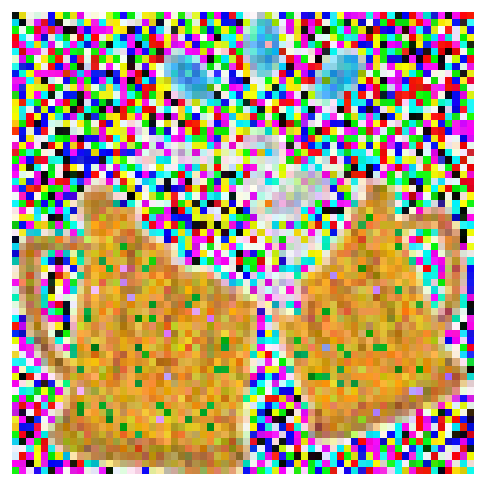

In [10]:
# Создание объекта расписания шума с определённым количеством временных шагов обучения
noise_scheduler = DDPMScheduler(num_train_timesteps=config.num_inference_steps)

# Генерация случайного шума той же формы, что и исходное изображение
noise = torch.randn(sample_image.shape)

# Определение временных шагов, для которых будет добавлен шум (здесь выбран шаг 50)
timesteps = torch.LongTensor([50])

# Добавление шума к исходному изображению на выбранном временном шаге
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

# Визуализация полученного зашумлённого изображения
plt.figure(figsize=(5, 5), dpi=120)
# Перестановка осей для корректного отображения, масштабирование значений пикселей и преобразование типа данных
plt.imshow(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])
plt.axis(False)  # Скрытие осей координат для чистого визуального представления
plt.show()  # Отображение зашумлённого изображения


# Обучение модели

In [12]:
# Предсказание модели для зашумлённого изображения
noise_pred = model(noisy_image, timesteps).sample
# Вычисление функции потерь как среднеквадратичной ошибки между предсказанным шумом и исходным
loss = F.mse_loss(noise_pred, noise)
# Инициализация оптимизатора AdamW с параметрами модели и заданной скоростью обучения
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
# Создание планировщика скорости обучения с косинусным затуханием и разогревом
lr_scheduler = get_cosine_schedule_with_warmup(optimizer=optimizer, num_warmup_steps=config.lr_warmup_steps, num_training_steps=(len(train_dataloader) * config.num_epochs))


# Функция для создания сетки изображений для визуализации
def make_grid(images, rows, cols):
    w, h = images[0].size  # Получение размеров одного изображения
    grid = Image.new('RGB', size=(cols*w, rows*h))  # Создание нового пустого изображения для сетки
    for i, image in enumerate(images):  # Размещение изображений в сетке
        grid.paste(image, box=(i%cols*w, i//cols*h))
    return grid

# Функция для оценки модели и сохранения результатов визуализации
def evaluate(config, epoch, pipeline):
    images = pipeline(batch_size=config.eval_batch_size, generator=torch.manual_seed(config.seed)).images  # Генерация изображений моделью
    image_grid = make_grid(images, rows=4, cols=4)  # Создание сетки из изображений
    test_dir = os.path.join(config.output_dir, "samples")  # Путь к директории для сохранения изображений
    os.makedirs(test_dir, exist_ok=True)  # Создание директории, если она не существует
    image_grid.save(f"{test_dir}/{epoch:04d}.png")  # Сохранение сетки изображений

# Функция для получения полного имени репозитория на Hugging Face Hub
def get_full_repo_name(model_id: str, organization: str = None, token: str = None):
    if token is None:
        token = HfFolder.get_token()  # Получение токена авторизации
    if organization is None:
        username = whoami(token)["name"]  # Получение имени пользователя
        return f"{username}/{model_id}"
    else:
        return f"{organization}/{model_id}"

# Главный цикл обучения модели
def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Инициализация Accelerator для оптимизации вычислений и совместимости с разными устройствами
    accelerator = Accelerator(mixed_precision=config.mixed_precision, gradient_accumulation_steps=config.gradient_accumulation_steps, log_with="tensorboard", project_dir=LOG_DIR)
    
    # Подготовка модели, оптимизатора, загрузчика данных и планировщика скорости обучения с помощью Accelerator
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(model, optimizer, train_dataloader, lr_scheduler)
    
    global_step = 0  # Счётчик глобальных шагов для логирования

    # Проход по эпохам обучения
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)  # Инициализация индикатора прогресса
        progress_bar.set_description(f"Epoch {epoch}")
        all_step_losses = []

        # Итерация по батчам датасета
        for step, batch in enumerate(train_dataloader):
            # Получение изображений из батча и перенос их на текущее устройство
            clean_images = batch['images']
            # Генерация шума с размером, соответствующим размеру изображений
            noise = torch.randn(clean_images.shape).to(clean_images.device)
            # Определение размера батча
            bs = clean_images.shape[0]
            # Выбор случайных временных шагов для каждого изображения в батче
            timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device).long()
            # Добавление шума к чистым изображениям
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            # Вычисление предсказаний модели и потерь
            with accelerator.accumulate(model):
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                # Обратное распространение ошибки
                accelerator.backward(loss)
                
                # Если активировано синхронное градиентное усечение
                if accelerator.sync_gradients:
                    # Усечение градиентов для стабилизации обучения
                    accelerator.clip_grad_norm_(model.parameters(), 1.0)
                
                # Шаг оптимизации
                optimizer.step()
                # Шаг планировщика скорости обучения
                lr_scheduler.step()
                # Обнуление градиентов
                optimizer.zero_grad()

            # Обновление индикатора прогресса и логирование
            progress_bar.update(1)
            all_step_losses.append(loss.detach().item())
            logs = {"epoch_loss": np.mean(all_step_losses), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # В конце каждой эпохи: генерация и сохранение изображений, сохранение модели
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            # Сохранение изображений и модели с заданными интервалами
            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline)

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                if config.push_to_hub:
                    repo.push_to_hub(commit_message=f"Epoch {epoch}", blocking=True)
                else:
                    pipeline.save_pretrained(config.output_dir)

# Запуск цикла обучения в определенном числе процессов (здесь: один процесс)
args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)
notebook_launcher(train_loop, args, num_processes=1)

args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)
notebook_launcher(train_loop, args, num_processes = 1)

Launching training on one GPU.


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

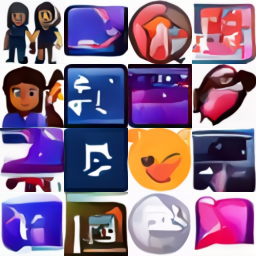

In [13]:
# Получаем путь к директории с изображениями, используя форматирование строки
# `config.output_dir` предполагается, что содержит путь к выходной директории
sample_images = sorted(Path(f"{config.output_dir}/samples/").glob("*.png"))
# `sorted` сортирует найденные файлы, `Path.glob("*.png")` ищет все файлы PNG в указанной директории

# Открываем последнее изображение в отсортированном списке
# `sample_images[-1]` получает последний элемент списка, т.е., последнее по алфавиту изображение
Image.open(sample_images[-1])


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

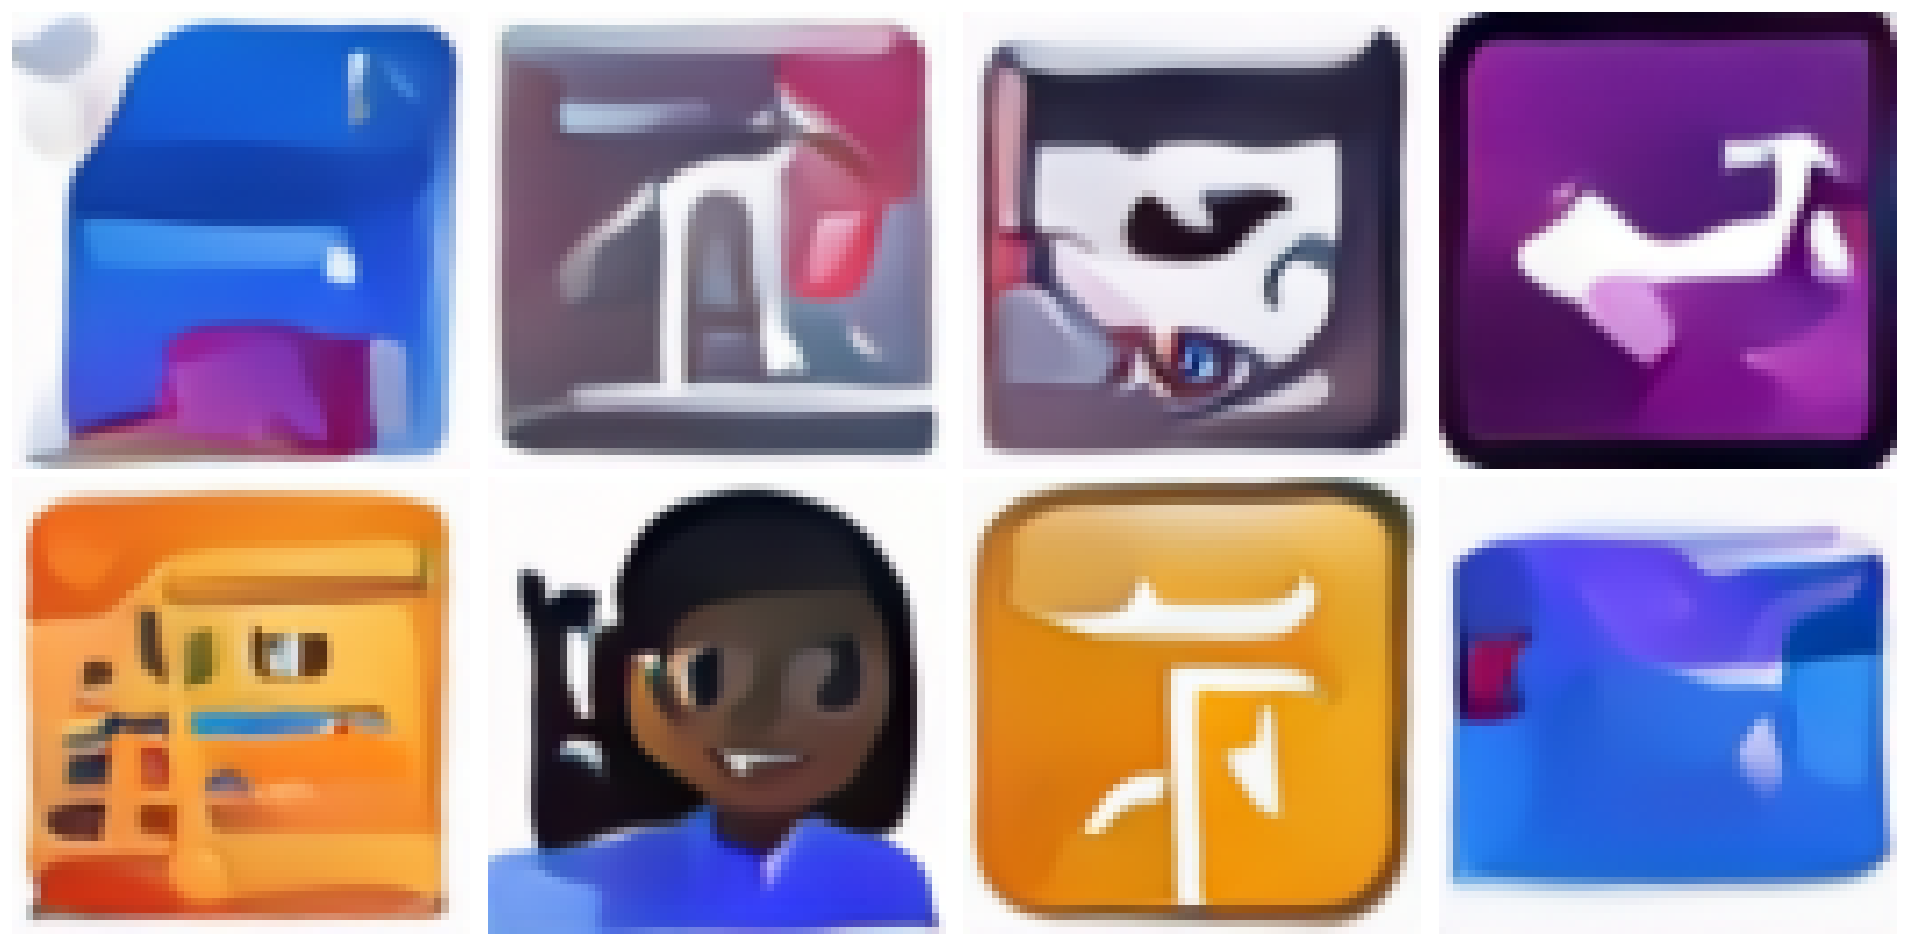

In [14]:
# Загрузка предварительно обученной модели Diffusion из указанной директории
ddpm = DDPMPipeline.from_pretrained(config.output_dir)
# Перемещение модели на устройство CUDA для ускорения вычислений на GPU
ddpm.to("cuda")

# Генерация изображений с использованием модели
# `batch_size=8` указывает, что будет сгенерировано 8 изображений за один проход
# `num_inference_steps=config.num_inference_steps` задаёт количество шагов инференса, определённое в конфигурации
inference_image = ddpm(
    batch_size = 8,
    num_inference_steps = config.num_inference_steps
).images

# Создание фигуры для визуализации результатов с размером и разрешением
plt.figure(figsize = (16, 8), dpi = 120)

# Визуализация каждого изображения в цикле
for i, image in enumerate(inference_image):
    # Для каждого изображения создаётся подграфик в сетке 2x4
    plt.subplot(2, 4, i + 1)
    # Отображение изображения
    plt.imshow(image)
    # Удаление осей для чистоты визуализации
    plt.axis(False)
# Автоматическая корректировка расположения подграфиков
plt.tight_layout()
# Отображение созданной фигуры с изображениями
plt.show()


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

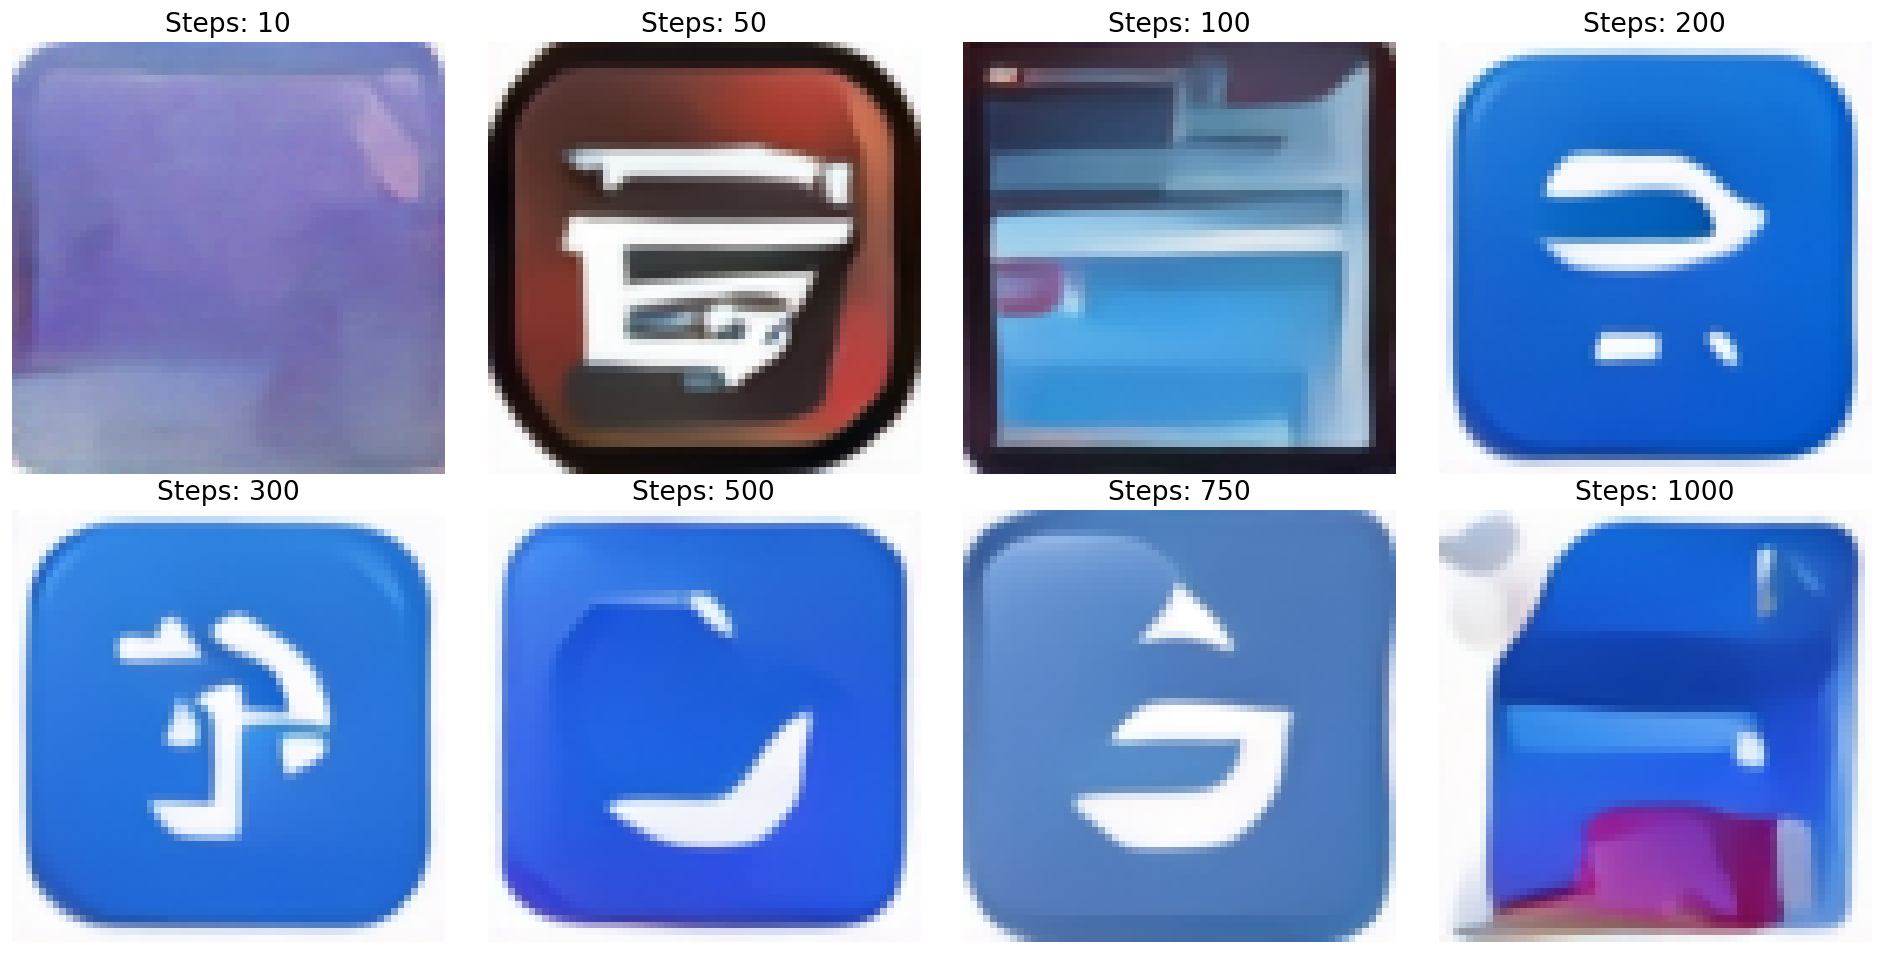

In [15]:
# Создание фигуры для визуализации с заданными размерами и разрешением
plt.figure(figsize = (16, 8), dpi = 120)

# Перебор различных долей от общего числа шагов инференса, заданных в конфигурации
for i, step_count in enumerate(
    # Масштабирование общего количества шагов инференса на заданные доли
    (np.array([0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.75, 1]) * config.num_inference_steps).astype(int)
):
    # Генерация одного изображения с заданным количеством шагов инференса и фиксированным начальным состоянием генератора
    inference_image = ddpm(
        batch_size = 1,  # Генерация одного изображения
        num_inference_steps = step_count,  # Использование рассчитанного количества шагов
        generator = torch.Generator(device = "cuda").manual_seed(config.seed)  # Фиксация случайности
    ).images[0]  # Получение первого и единственного изображения из результатов

    # Добавление подграфика в сетку 2x4
    plt.subplot(2, 4, i + 1)
    # Отображение сгенерированного изображения
    plt.imshow(inference_image)
    # Добавление заголовка с указанием количества шагов
    plt.title(f"Steps: {step_count}", fontsize = 16)
    # Удаление осей для лучшей визуализации
    plt.axis(False)

# Автоматическая корректировка расположения элементов на фигуре
plt.tight_layout()
# Отображение фигуры с подграфиками
plt.show()
